In [1]:
'''This example demonstrates the use of fasttext for text classification

Based on Joulin et al's paper:

Bags of Tricks for Efficient Text Classification
https://arxiv.org/abs/1607.01759

Results on IMDB datasets with uni and bi-gram embeddings:
    Uni-gram: 0.8813 test accuracy after 5 epochs. 8s/epoch on i7 cpu.
    Bi-gram : 0.9056 test accuracy after 5 epochs. 2s/epoch on GTx 980M gpu.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb
from keras import backend as K


import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))



# Import DeepExplain
from deepexplain.tensorflow import DeepExplain, ProbDense

Using TensorFlow backend.


In [2]:
import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer

max_words = 1200
batch_size = 64
epochs = 20

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Vectorizing sequence data...')
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('Building model...')
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Loading data...
8982 train sequences
2246 test sequences
46 classes
Vectorizing sequence data...
x_train shape: (8982, 1200)
x_test shape: (2246, 1200)
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (8982, 46)
y_test shape: (2246, 46)
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               614912    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
activation_2 (Activation)    (None,

In [6]:
xs = x_test[:10]
ys = y_test[:10]
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    

    
    a_gradin = de.explain('grad*input', target_tensor, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor, input_tensor, xs)
    a_res = de.explain('deeplift', target_tensor, input_tensor, xs)
    a_rc = de.explain('deeplift_rc', target_tensor, input_tensor, xs)
    #a_linear = de.explain('linear', target_tensor * ys, input_tensor, xs)
    a_layershap = de.explain('shapley', target_tensor, input_tensor, xs)
    #a_shap = np.zeros_like(a_linear)
    
    #attributions2 = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    a_occl = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")

DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
{<tf.Tensor 'dense_1_input:0' shape=(?, 1200) dtype=float32>: array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]]), <tf.Tensor 'dropout_1/keras_learning_phase/input:0' shape=() dtype=bool>: 0}
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
{<tf.Tensor 'dense_1_input:0' shape=(?, 1200) dtype=float32>: array([[0.  , 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.01, ..., 0.  , 0.  , 0.  ]]), <tf.Tensor 'dropout_1/keras_learning_phase/input:0' shape=() d

/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:413: RuntimeWarning: divide by zero encountered in true_divide
  t = (i / (2 * vars[:, :, np.newaxis] * Xs[np.newaxis, np.newaxis, :]) ** 0.5)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:414: RuntimeWarning: divide by zero encountered in true_divide
  tb = (ib / (2 * vars[:, :, np.newaxis] * Xs[np.newaxis, np.newaxis, :]) ** 0.5)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:420: RuntimeWarning: overflow encountered in square
  exp1 = e ** -(t ** 2)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:421: RuntimeWarning: overflow encountered in square
  exp2 = e ** -(tb ** 2)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:453: RuntimeWarning: invalid value encountered in true_divide
  eta =  np.where(np.abs(deltas) > 1e-6, shap / deltas, np.zeros_like(shap))


None
MatMul override:  model_2/dense_1/MatMul
Players (10, 1200)
Weights (1200, 512)
Reference (1, 1200)
Original grad (?, 1200)
Eta shap [approx] games[(10, 1200, 512)], bias[(512,)], baseline[(10, 1200, 512)]
Reshape: games[(10, 1200, 512)], bias[(512,)], baseline[(10, 1200, 512)]
{<tf.Tensor 'dense_1_input:0' shape=(?, 1200) dtype=float32>: array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]]), <tf.Tensor 'dropout_1/keras_learning_phase/input:0' shape=() dtype=bool>: 0}
DeepExplain: running "occlusion" explanation method (9)
Model with multiple inputs:  False
Input shape: (1200,); window_shape (1,); step 1
{<tf.Tensor 'dense_1_input:0' shape=(?, 1200) dtype=float32>: array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [

In [17]:
print (a_occl[0])
print (max_words)

[0.         0.3769579  0.00783157 ... 0.         0.         0.        ]
1200


Text(0.5, 1.0, 'Occlusion')

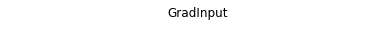

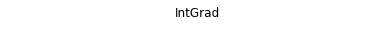

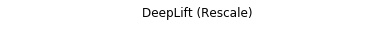

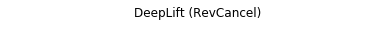

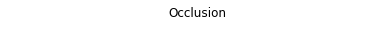

In [18]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
idx =1
shape = (1, a_gradin.shape[1])
plot(a_gradin[idx].reshape(shape)).title('GradInput')
plt.figure()
plot(a_intgrad[idx].reshape(shape)).title('IntGrad')
plt.figure()
plot(a_res[idx].reshape(shape)).title('DeepLift (Rescale)')
#plt.figure()
#plot((a_linear)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Linear')
plt.figure()
plot(a_rc[idx].reshape(shape)).title('DeepLift (RevCancel)')
plt.figure()
# plot((a_shap)[idx].reshape(shape)).title('Deep Shap')
# plt.figure()
# plot((a_shap2)[idx].reshape(shape)).title('Deep Shap (no Keras)')
# plt.figure()
plot((a_occl)[idx].reshape(shape)).title('Occlusion')

# plot((a_layershap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Layerwise Shap')
# plt.figure()
#plot((a_shaplud)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('SHAP')
#plt.figure()
#plot((a_exact)[idx].reshape(shape)).title('Exact Shap')